In [29]:
import numpy as np
import matplotlib.pyplot as plt
# experiment 1
adj_matrix = np.array([
    [0, 1, 1, 0, 0],  #  1 -> 2, 3, 
    [0, 0, 1, 0, 1],  #  2 -> 3, 5
    [0, 0, 0, 0, 1],  #  3 -> 5
    [1, 0, 0, 0, 0],  #  4 -> 1
    [0, 0, 1, 1, 0],  #  5 -> 3, 4
])

num_nodes = adj_matrix.shape[0]  
initial_values = np.array([4, 5, 6, 3, 2], dtype=float)  
target_mean = np.mean(initial_values)  
print('target_mean:', target_mean)
iterations = 50  
epsilon = 1e-6  

target_mean: 4.0


In [30]:
import random

def initialize_weights(adj_matrix, method="equal"):
    num_nodes = adj_matrix.shape[0]
    weights = np.zeros((num_nodes, num_nodes))
    P_bar = np.zeros((num_nodes, num_nodes))

    out_degrees = np.sum(adj_matrix, axis=1) 
    in_degrees  = np.sum(adj_matrix, axis=0)
    print("out_degrees: \n", out_degrees)
    C_plus = np.zeros(num_nodes)  
    C_minus = np.zeros(num_nodes)

    # C^+_j（
    for j in range(num_nodes):
        neighbors = np.where(adj_matrix[:, j] == 1)[0]  # the neighbours it can reach
        if len(neighbors) > 0:
            C_plus[j] = np.sum(out_degrees[neighbors])
    
    #C^-_j
    for j in range(num_nodes):
        neighbors = np.where(adj_matrix[:, j] == 1)[0]  # the neighbours it can reach
        if len(neighbors) > 0:
            C_minus[j] = np.sum(in_degrees[neighbors])

    # P_bar
    for j in range(num_nodes):
        for i in range(num_nodes):
            if adj_matrix[j, i] == 1:  # only connected 
                if method == "equal":
                    P_bar[i, j] = 1 / out_degrees[j]
                elif method == "out-degree":
                    P_bar[i, j] = out_degrees[i] / max(C_plus[j], epsilon)  # avoid divide 0
                elif method == "inverse-out-degree":
                    P_bar[i, j] = (1 / out_degrees[i]) / max(C_plus[j], epsilon)
                elif method == "random":
                    P_bar[i, j] = random.randint(0, 100)
                elif method == "in-degree":
                    P_bar[i, j] = in_degrees[i] / max(C_minus[j], epsilon)
                elif method == "inverse-in-degree":
                    P_bar[i, j] = (1 / in_degrees[i]) / max(C_minus[j], epsilon)

    colsum = np.sum(P_bar, axis=0)
    P_bar = P_bar / colsum
    # initial diag  pjj[0] = 1 / (1 + D^+)
    for i in range(num_nodes):
        weights[i, i] = 1 / (out_degrees[i] + 1)
    # print("weights: \n", weights)
    delta = np.diag(1 - weights.diagonal())
    weights = P_bar @ delta + (np.eye(num_nodes) - delta)
    # print("delta: \n", delta)
    # print("P_bar: \n", P_bar)
    # print("weights: \n", weights)
    print("Returning: ", weights.shape, delta.shape, P_bar.shape)

    return weights, delta, P_bar

initialize_weights(adj_matrix, method="inverse-out-degree")


out_degrees: 
 [2 2 1 1 2]
Returning:  (5, 5) (5, 5) (5, 5)


(array([[0.33333333, 0.        , 0.        , 0.5       , 0.        ],
        [0.22222222, 0.33333333, 0.        , 0.        , 0.        ],
        [0.44444444, 0.44444444, 0.5       , 0.        , 0.33333333],
        [0.        , 0.        , 0.        , 0.5       , 0.33333333],
        [0.        , 0.22222222, 0.5       , 0.        , 0.33333333]]),
 array([[0.66666667, 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.66666667, 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.5       , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.5       , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.66666667]]),
 array([[0.        , 0.        , 0.        , 1.        , 0.        ],
        [0.33333333, 0.        , 0.        , 0.        , 0.        ],
        [0.66666667, 0.66666667, 0.        , 0.        , 0.5       ],
        [0.        , 0.        , 0.        , 0.        , 0.5       ],
        [0.     

need update

In [31]:
def run_dynamic_consensus(adj_matrix, method, initial_values, tolerance=1e-6, max_iterations=1000):
    num_nodes = adj_matrix.shape[0]
    values = initial_values.copy()
    weights, delta, P_bar = initialize_weights(adj_matrix, method)

    row_sum_errors = []
    mean_errors = []
    iteration = 0
    consensus_reached = False

    while not consensus_reached and iteration < max_iterations:
        iteration += 1

        row_sums = np.sum(weights, axis=1)
        print(f"Iteration {iteration} row_sums: \n", row_sums)

        for j in range(num_nodes):
            rho_j = row_sums[j]
            if rho_j <= 1:
                delta_j = delta[j, j] * rho_j
            else:
                delta_j = 1 - (1 - delta[j, j]) / rho_j  # Adjust delta based on rho_j
            delta[j, j] = delta_j

        print(f"Iteration {iteration} delta: \n", delta)
        weights = P_bar @ delta + (np.eye(num_nodes) - delta)
        print(f"Iteration {iteration} weights: \n", weights)
        new_values = weights @ values  # Update values

        row_sum_error = np.sum(np.abs(np.sum(weights, axis=0) - 1))
        mean_error = np.mean(np.abs(new_values - np.mean(new_values)))

        row_sum_errors.append(row_sum_error)
        mean_errors.append(mean_error)

        values = new_values

        print(f"Iteration {iteration} values:", values)
        print(f"Iteration {iteration} mean error:", mean_error)

        if mean_error < tolerance:
            print(f"Consensus reached at iteration {iteration} with mean error {mean_error:.6f}")
            consensus_reached = True

    if not consensus_reached:
        print(f"Maximum iterations reached ({max_iterations}). Consensus not achieved.")
        
    return row_sum_errors, mean_errors


out_degrees: 
 [2 2 1 1 2]
Returning:  (5, 5) (5, 5) (5, 5)
Iteration 1 row_sums: 
 [0.83333333 0.66666667 1.5        0.83333333 1.16666667]
Iteration 1 delta: 
 [[0.55555556 0.         0.         0.         0.        ]
 [0.         0.44444444 0.         0.         0.        ]
 [0.         0.         0.66666667 0.         0.        ]
 [0.         0.         0.         0.41666667 0.        ]
 [0.         0.         0.         0.         0.71428571]]
Iteration 1 weights: 
 [[0.44444444 0.         0.         0.41666667 0.        ]
 [0.27777778 0.55555556 0.         0.         0.        ]
 [0.27777778 0.22222222 0.33333333 0.         0.35714286]
 [0.         0.         0.         0.58333333 0.35714286]
 [0.         0.22222222 0.66666667 0.         0.28571429]]
Iteration 1 values: [3.02777778 3.88888889 4.93650794 2.46428571 5.68253968]
Iteration 1 mean error: 1.0476190476190472
Iteration 2 row_sums: 
 [0.86111111 0.83333333 1.19047619 0.94047619 1.17460317]
Iteration 2 delta: 
 [[0.4783950

/var/folders/jj/yj1r8p1s23sgk5x98428488r0000gn/T/ipykernel_30390/3818841848.py:13: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(eq_row_errors), label="Equal Weighting", linestyle='-', marker='o')
/var/folders/jj/yj1r8p1s23sgk5x98428488r0000gn/T/ipykernel_30390/3818841848.py:14: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(od_row_errors), label="Out-Degree Weighting", linestyle='--', marker='s')
/var/folders/jj/yj1r8p1s23sgk5x98428488r0000gn/T/ipykernel_30390/3818841848.py:15: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(iod_row_errors), label="Inverse-Out-Degree Weighting", linestyle='--', marker='^')
/var/folders/jj/yj1r8p1s23sgk5x98428488r0000gn/T/ipykernel_30390/3818841848.py:16: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(id_row_errors), label="In-Degree Weighting", linestyle='-.', marker='d')
/var/folders/jj/yj1r8p1s23sgk5x98428488r0000gn/T/ipykernel_30390/3818841848.py:17:

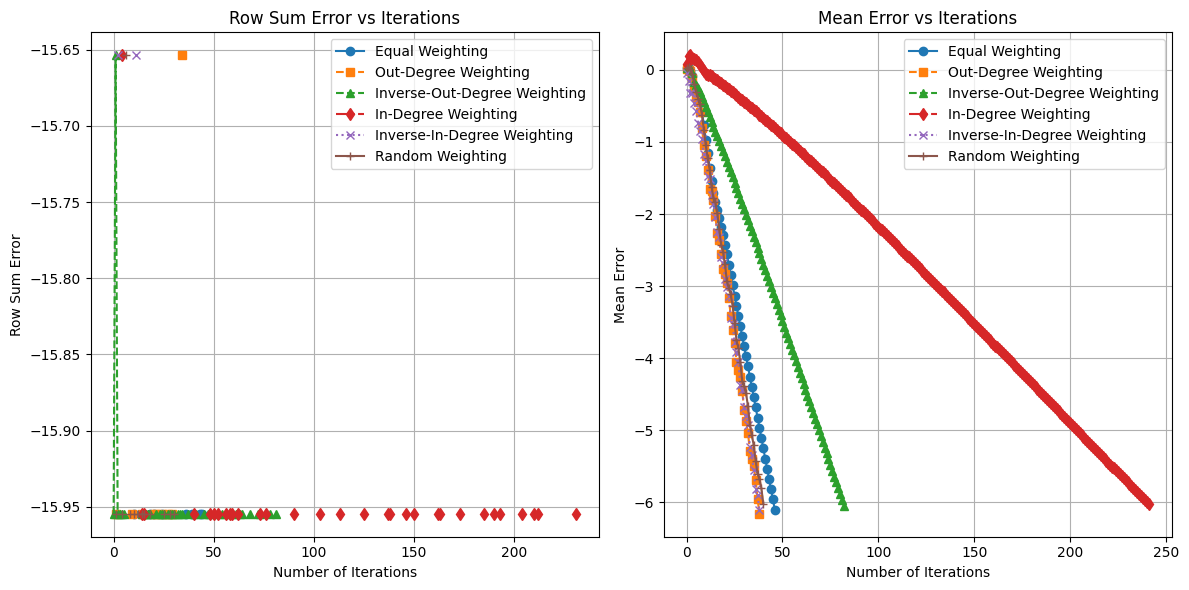

In [32]:
eq_row_errors, eq_mean_errors = run_dynamic_consensus(adj_matrix, "equal", initial_values)
od_row_errors, od_mean_errors = run_dynamic_consensus(adj_matrix, "out-degree", initial_values)
iod_row_errors, iod_mean_errors = run_dynamic_consensus(adj_matrix, "inverse-out-degree", initial_values)
id_row_errors, id_mean_errors = run_dynamic_consensus(adj_matrix, "in-degree", initial_values)
iid_row_errors, iid_mean_errors = run_dynamic_consensus(adj_matrix, "inverse-in-degree", initial_values)
rd_row_errors, rd_mean_errors = run_dynamic_consensus(adj_matrix, "random", initial_values)

# Plotting
plt.figure(figsize=(12, 6))

# Row Sum Error vs Iterations
plt.subplot(1, 2, 1)
plt.plot(np.log10(eq_row_errors), label="Equal Weighting", linestyle='-', marker='o')
plt.plot(np.log10(od_row_errors), label="Out-Degree Weighting", linestyle='--', marker='s')
plt.plot(np.log10(iod_row_errors), label="Inverse-Out-Degree Weighting", linestyle='--', marker='^')
plt.plot(np.log10(id_row_errors), label="In-Degree Weighting", linestyle='-.', marker='d')
plt.plot(np.log10(iid_row_errors), label="Inverse-In-Degree Weighting", linestyle=':', marker='x')
plt.plot(np.log10(rd_row_errors), label="Random Weighting", linestyle='-', marker='+')
plt.xlabel("Number of Iterations")
plt.ylabel("Row Sum Error")
plt.title("Row Sum Error vs Iterations")
plt.legend()
plt.grid(True)

# Mean Error vs Iterations
plt.subplot(1, 2, 2)
plt.plot(np.log10(eq_mean_errors), label="Equal Weighting", linestyle='-', marker='o')
plt.plot(np.log10(od_mean_errors), label="Out-Degree Weighting", linestyle='--', marker='s')
plt.plot(np.log10(iod_mean_errors), label="Inverse-Out-Degree Weighting", linestyle='--', marker='^')
plt.plot(np.log10(id_mean_errors), label="In-Degree Weighting", linestyle='-.', marker='d')
plt.plot(np.log10(iid_mean_errors), label="Inverse-In-Degree Weighting", linestyle=':', marker='x')
plt.plot(np.log10(rd_mean_errors), label="Random Weighting", linestyle='-', marker='+')
plt.xlabel("Number of Iterations")
plt.ylabel("Mean Error")
plt.title("Mean Error vs Iterations")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

target_mean: 65.0


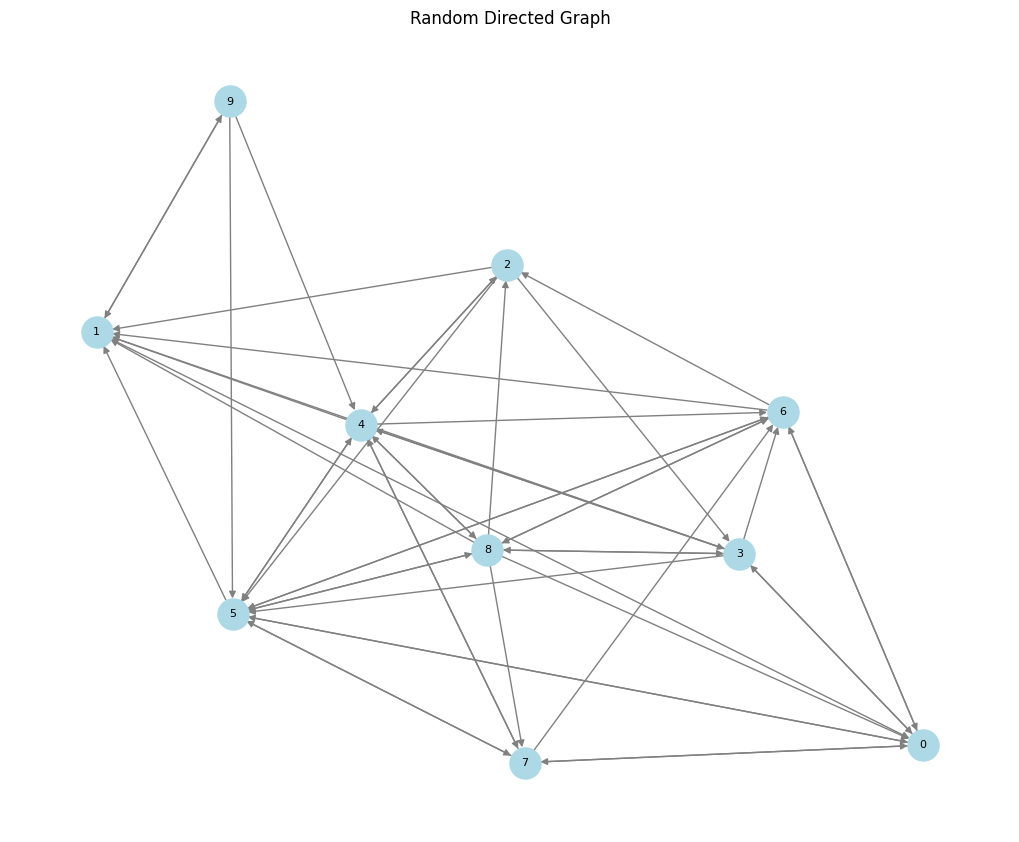

In [33]:
import networkx as nx
num_nodes = 10
edge_probability = 0.5  # Adjust this probability as desired
G = nx.erdos_renyi_graph(num_nodes, edge_probability, directed=True)

# Get the adjacency matrix from the graph
adjacency_matrix = nx.to_numpy_array(G)

# Generate random integer values for each node
node_values = np.random.randint(0, 100, size=num_nodes)
target_mean = np.mean(node_values)
print('target_mean:', target_mean)

# Visualize the random directed graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)  # Layout for better visualization
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=8)
plt.title("Random Directed Graph")
plt.show()


out_degrees: 
 [2 2 1 1 2]
Returning:  (5, 5) (5, 5) (5, 5)
Iteration 1 row_sums: 
 [0.83333333 0.66666667 1.5        0.83333333 1.16666667]
Iteration 1 delta: 
 [[0.55555556 0.         0.         0.         0.        ]
 [0.         0.44444444 0.         0.         0.        ]
 [0.         0.         0.66666667 0.         0.        ]
 [0.         0.         0.         0.41666667 0.        ]
 [0.         0.         0.         0.         0.71428571]]
Iteration 1 weights: 
 [[0.44444444 0.         0.         0.41666667 0.        ]
 [0.27777778 0.55555556 0.         0.         0.        ]
 [0.27777778 0.22222222 0.33333333 0.         0.35714286]
 [0.         0.         0.         0.58333333 0.35714286]
 [0.         0.22222222 0.66666667 0.         0.28571429]]
Iteration 1 values: [3.02777778 3.88888889 4.93650794 2.46428571 5.68253968]
Iteration 1 mean error: 1.0476190476190472
Iteration 2 row_sums: 
 [0.86111111 0.83333333 1.19047619 0.94047619 1.17460317]
Iteration 2 delta: 
 [[0.4783950

/var/folders/jj/yj1r8p1s23sgk5x98428488r0000gn/T/ipykernel_30390/3818841848.py:13: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(eq_row_errors), label="Equal Weighting", linestyle='-', marker='o')
/var/folders/jj/yj1r8p1s23sgk5x98428488r0000gn/T/ipykernel_30390/3818841848.py:14: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(od_row_errors), label="Out-Degree Weighting", linestyle='--', marker='s')
/var/folders/jj/yj1r8p1s23sgk5x98428488r0000gn/T/ipykernel_30390/3818841848.py:15: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(iod_row_errors), label="Inverse-Out-Degree Weighting", linestyle='--', marker='^')
/var/folders/jj/yj1r8p1s23sgk5x98428488r0000gn/T/ipykernel_30390/3818841848.py:16: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(id_row_errors), label="In-Degree Weighting", linestyle='-.', marker='d')
/var/folders/jj/yj1r8p1s23sgk5x98428488r0000gn/T/ipykernel_30390/3818841848.py:17:

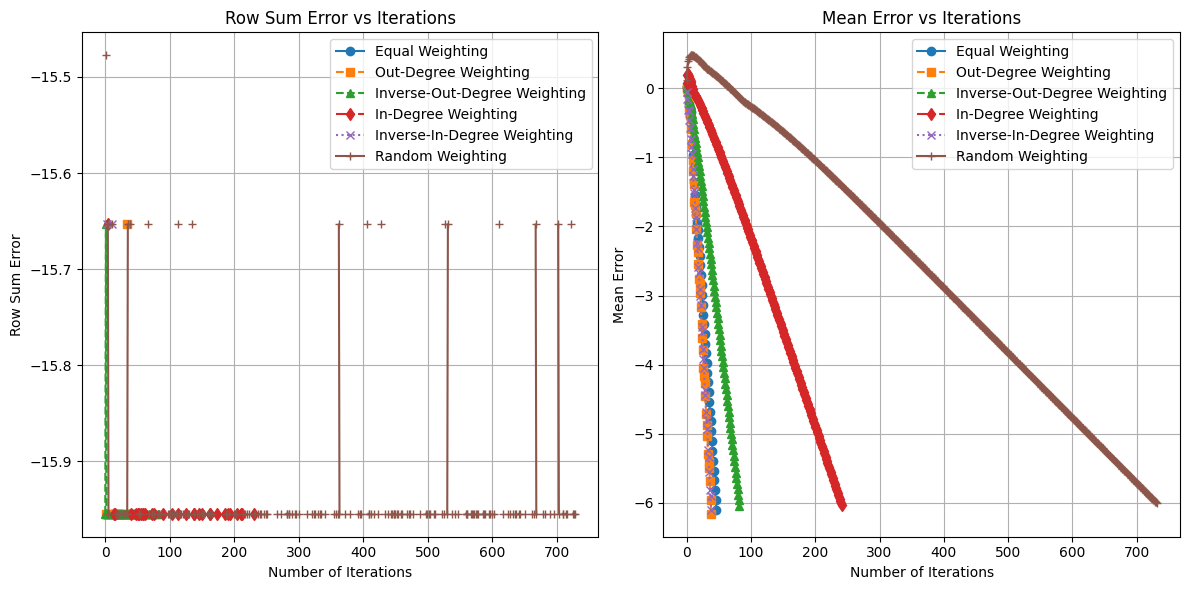

In [34]:
eq_row_errors, eq_mean_errors = run_dynamic_consensus(adj_matrix, "equal", initial_values)
od_row_errors, od_mean_errors = run_dynamic_consensus(adj_matrix, "out-degree", initial_values)
iod_row_errors, iod_mean_errors = run_dynamic_consensus(adj_matrix, "inverse-out-degree", initial_values)
id_row_errors, id_mean_errors = run_dynamic_consensus(adj_matrix, "in-degree", initial_values)
iid_row_errors, iid_mean_errors = run_dynamic_consensus(adj_matrix, "inverse-in-degree", initial_values)
rd_row_errors, rd_mean_errors = run_dynamic_consensus(adj_matrix, "random", initial_values)

# Plotting
plt.figure(figsize=(12, 6))

# Row Sum Error vs Iterations
plt.subplot(1, 2, 1)
plt.plot(np.log10(eq_row_errors), label="Equal Weighting", linestyle='-', marker='o')
plt.plot(np.log10(od_row_errors), label="Out-Degree Weighting", linestyle='--', marker='s')
plt.plot(np.log10(iod_row_errors), label="Inverse-Out-Degree Weighting", linestyle='--', marker='^')
plt.plot(np.log10(id_row_errors), label="In-Degree Weighting", linestyle='-.', marker='d')
plt.plot(np.log10(iid_row_errors), label="Inverse-In-Degree Weighting", linestyle=':', marker='x')
plt.plot(np.log10(rd_row_errors), label="Random Weighting", linestyle='-', marker='+')
plt.xlabel("Number of Iterations")
plt.ylabel("Row Sum Error")
plt.title("Row Sum Error vs Iterations")
plt.legend()
plt.grid(True)

# Mean Error vs Iterations
plt.subplot(1, 2, 2)
plt.plot(np.log10(eq_mean_errors), label="Equal Weighting", linestyle='-', marker='o')
plt.plot(np.log10(od_mean_errors), label="Out-Degree Weighting", linestyle='--', marker='s')
plt.plot(np.log10(iod_mean_errors), label="Inverse-Out-Degree Weighting", linestyle='--', marker='^')
plt.plot(np.log10(id_mean_errors), label="In-Degree Weighting", linestyle='-.', marker='d')
plt.plot(np.log10(iid_mean_errors), label="Inverse-In-Degree Weighting", linestyle=':', marker='x')
plt.plot(np.log10(rd_mean_errors), label="Random Weighting", linestyle='-', marker='+')
plt.xlabel("Number of Iterations")
plt.ylabel("Mean Error")
plt.title("Mean Error vs Iterations")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()